In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Processing data
---

This notebook provides an example for how to process `e11.H5Scan()` and `e11.H5Data()` datasets.

In [3]:
from e11 import H5Scan, H5Data

# `e11.H5Scan()`
---

In [4]:
fil = os.path.join(os.getcwd(), 'example_data', 'microwave_scan.h5')
scan = H5Scan(fil)

To analyse array datasets it can be helpful to convert the data to an instance of `xarray.DataArray`, to which we can map coordinates for each axis.

First, we load up the array and map the time and analysis values to each axis.

In [5]:
var = scan.attrs()['var']
arr = scan.array('osc_0')
info = scan.attrs('osc_0')
dt = info['dt']
df = scan.df('analysis')
# xarray
tvals = np.arange(arr.shape[1]) * dt * 1e6
analysis = {col : ('measurement', df[col].values) for col in df.columns}
da = xr.DataArray(arr * 1e3,
                  coords={'measurement':df.index, 'time (us)':tvals, **analysis},
                  dims=('measurement', 'time (us)'))
print(da)

<xarray.DataArray (measurement: 140, time (us): 1000)>
array([[ 0.526563,  0.542188,  0.542188, ..., -2.434375, -2.426562, -2.442187],
       [ 0.464063,  0.471875,  0.464063, ..., -2.598438, -2.590625, -2.614063],
       [ 0.464063,  0.45625 ,  0.440625, ..., -2.48125 , -2.504688, -2.496875],
       ...,
       [-0.145312, -0.145312, -0.160937, ..., -3.098438, -3.090625, -3.082813],
       [ 0.471875,  0.464063,  0.4875  , ..., -2.496875, -2.5125  , -2.5125  ],
       [ 0.58125 ,  0.565625,  0.557813, ..., -2.582813, -2.582813, -2.567188]])
Coordinates:
  * measurement  (measurement) int64 0 1 2 3 4 5 6 ... 134 135 136 137 138 139
  * time (us)    (time (us)) float64 0.0 0.001 0.002 0.003 ... 0.997 0.998 0.999
    var          (measurement) float64 32.05 32.05 32.05 ... 32.12 32.12 32.12
    w0           (measurement) float64 778.0 778.0 778.0 ... 778.0 778.0 778.0
    w1           (measurement) float64 787.0 787.0 787.0 ... 787.0 787.0 787.0
    a0           (measurement) float64 0.0

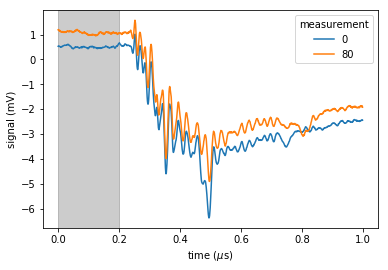

In [6]:
# plot
fig, ax = plt.subplots()

# data
da.isel({"measurement":[0, 80]}).plot.line(x='time (us)')

# background
t_bk = (0.0, 0.2)
ax.axvspan(*t_bk, color='k', alpha=0.2)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (mV)')

# output
plt.show()

Next, we'll subtract the offset from each trace (mean value of the shaded region) and then subtract the average trace to find where the signal changes. 

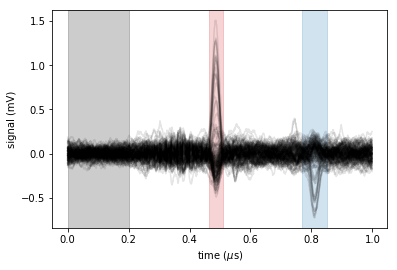

In [7]:
# plot
fig, ax = plt.subplots()

bksub = da - da.loc[:, slice(*t_bk)].mean(dim='time (us)')
bksub -= bksub.mean(dim='measurement')

# data
bksub.plot.line(x='time (us)', c="k", alpha=0.1, add_legend=False)

# background
ax.axvspan(*t_bk, color='k', alpha=0.2)

# signal 0
t_sig0 = (0.465, 0.510)
ax.axvspan(*t_sig0, color='C3', alpha=0.2)
# signal 1
t_sig1 = (0.77, 0.85)
ax.axvspan(*t_sig1, color='C0', alpha=0.2)

# format
ax.set_xlabel('time ($\mu$s)')
ax.set_ylabel('signal (mV)')

# output
plt.show()

For multiple measurements associated with identical var values, the `xarray` tools for grouping and averaging can be useful.

In [8]:
# combine repeat measurements for the same var values
try:
    # with repeats
    av_bksub = bksub.groupby("var").mean(dim='measurement')
except ValueError:
    # no repeats
    av_bksub = bksub
except:
    raise

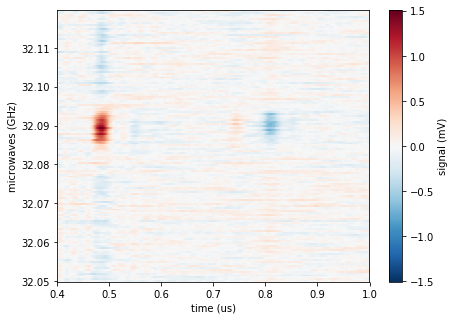

In [9]:
# plot 2D
fig, ax = plt.subplots(figsize=(7, 5))

# data
p0 = av_bksub.loc[:, 0.4:1.0].plot()
p0.colorbar.set_label("signal (mV)")
ax.set_ylabel(var)
plt.show()

Now, we calculate the difference between the mean value of the traces in the two regions of interest (shaded regions where the signal changes).

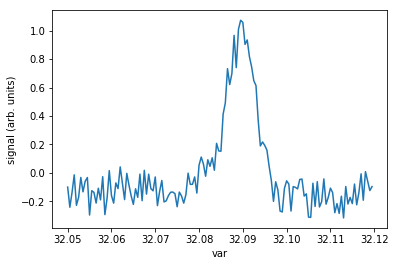

In [10]:
sig0 = av_bksub.loc[:, slice(*t_sig0)].mean(dim=("time (us)")).to_series().rename("sig0")
sig1 = av_bksub.loc[:, slice(*t_sig1)].mean(dim=("time (us)")).to_series().rename("sig1")
result = (sig0 - sig1).rename("result")

# plot
fig, ax = plt.subplots()
result.plot(ax=ax)
ax.set_ylabel("signal (arb. units)")
plt.show()

# `e11.H5Data()`
---

`H5Data` files are typically very large and it's often not reasonable to load _all_ of the data into memory at once.  However, the datasets are seperated into groups, therefore, it's logical to process each one seperately and then combine the results.

The functions in the module `e11.process` can be mapped to the datasets inside of each group using the class method `H5Data.apply()`.  The result is a `pandas.DataFrame` that is indexed by the group ID (`squid`).  This makes it easy to keep track of the relationships between the results and the group attributes, e.g., the experimental settings.

In [11]:
from e11.process import vrange, mean, mean_std

### vertical range

Here, we are applying the `vrange` function to measure the vertical range of array data in all of the groups.

In [12]:
# load data
fil = os.path.join(os.getcwd(), 'example_data', 'array_data.h5')
data = H5Data(fil)

In [13]:
rng, r_info = data.apply(vrange, data.squids, ['OSC_0'], name='vr',
                         get_info=True)
rng.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.09sq/s]


vr
squid measurement          
1     0            1.033028
      1            1.012191
      2            1.032403
      3            1.070328
      4            1.062143

In [14]:
rng.describe()

,vr
count,151.000000
mean,1.039718
std,0.015097
min,0.997321
25%,1.031731
50%,1.041619
75%,1.050006
max,1.083854


In [15]:
# information about the processing
r_info

{'self': 'H5Data',
 'func': 'vrange',
 'squids': array([1, 2, 3, 4, 5, 6]),
 'dataset': ['OSC_0'],
 'name': 'vr',
 'method': 'apply',
 'datetime': '2019-03-29 17:42:11',
 'cache': False}

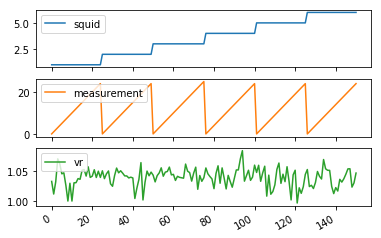

In [16]:
# plot
rng.reset_index().plot(subplots=True)

#output
plt.show()

### `H5Data.apply()` with multiple datasets

Processing can be applied to multiple datasets at once (in the example below it's `OSC_0`, twice).  The kwarg `keys` is used to name the columns in the result.

In [17]:
avg = data.apply(mean, data.squids, ['OSC_0', 'OSC_0'],
                 keys=['av_A', 'av_B'])
avg.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 150.09sq/s]


av_A      av_B
squid measurement                    
1     0            0.738350  0.738350
      1            0.738752  0.738752
      2            0.738586  0.738586
      3            0.738578  0.738578
      4            0.738438  0.738438

In [18]:
sta = data.apply(mean_std, data.squids, ['OSC_0', 'OSC_0'],
                 keys=['A', 'B'])
sta.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 111.18sq/s]


A                   B          
                       mean       std      mean       std
squid measurement                                        
1     0            0.738350  0.423929  0.738350  0.423929
      1            0.738752  0.423923  0.738752  0.423923
      2            0.738586  0.423920  0.738586  0.423920
      3            0.738578  0.423958  0.738578  0.423958
      4            0.738438  0.423983  0.738438  0.423983

### `H5Data.apply()` with lambda functions

The functions in `e11.process` are just examples of the sort that can be used with the `H5Data.apply()` method.  Actually, any function that returns either a `pandas.Series()` or a `pandas.DataFrame()` _should_ work, including lambda functions.

In [19]:
mx = data.apply(lambda arr: pd.Series(np.max(arr, axis=1), name="max"),
                data.squids, 'OSC_0')
mx.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 214.43sq/s]


squid   
1      0    1.035434
       1    1.015597
       2    1.035778
       3    1.072609
       4    1.064456
Name: max, dtype: float64

The function must accept kwargs if you call _apply()_ with any.  If you call _apply()_ with multiple datasets they are passed to the function as an unpacked list.  This opens up the possibility of doing more sophisticated processing that combines data from several datasets.

In [20]:
mxs = data.apply(lambda *arr, **kwargs: pd.DataFrame(np.array([np.max(arr[0], axis=1),
                                                               np.min(arr[1], axis=1)]).T,
                                                     columns=kwargs["columns"]),
                 data.squids, ['OSC_0', 'OSC_0'], columns=["max_0", "min_1"])
mxs.head()

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 171.53sq/s]


max_0     min_1
squid                      
1     0  1.035434  0.002406
      1  1.015597  0.003406
      2  1.035778  0.003375
      3  1.072609  0.002281
      4  1.064456  0.002313